In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel

In [19]:
# Cargar los datos, saltando las primeras filas que no son datos de usuarios
url = "https://github.com/fantasmarobapan/datasetProyecto/raw/refs/heads/main/guess_proyecto3_datos.xlsx"
data = pd.read_excel(url, sheet_name="Sheet1")

# Mostrar las primeras filas para verificar
print(data.head())

  user_id version  AE1  AE2  AE3  AE4  PE1  PE2  PE3  PE4  ...  US2  US3  US4  \
0  user_1      v1    5    5    4    3    4    5    5    5  ...    4    4    5   
1  user_2      v1    5    7    4    4    5    5    4    5  ...    4    3    4   
2  user_3      v1    6    5    4    4    6    5    5    5  ...    7    5    4   
3  user_4      v1    5    4    5    6    5    6    4    4  ...    6    6    5   
4  user_5      v1    5    4    3    5    4    4    5    5  ...    3    3    5   

   US5  US6  US7  VA1  VA2  VA3  VA4  
0    6    3    6    4    5    5    4  
1    3    5    4    4    5    3    4  
2    5    5    3    2    5    5    5  
3    3    5    3    6    4    4    4  
4    5    4    4    4    4    5    5  

[5 rows x 47 columns]


In [20]:
# Definir las subdimensiones y sus códigos
subdimensiones = {
    "Aesthetics": ["AE1", "AE2", "AE3", "AE4"],
    "Play Engrossment": ["PE1", "PE2", "PE3", "PE4", "PE5", "PE6", "PE7"],
    "Enjoyment": ["EN1", "EN2", "EN3", "EN4", "EN5", "EN6"],
    "Personal Gratification": ["PG1", "PG2", "PG3", "PG4"],
    "Creative Freedom": ["CF1", "CF2", "CF3", "CF4"],
    "Social Connectivity": ["SC1", "SC2", "SC3", "SC4", "SC5"],
    "Narrative": ["NA1", "NA2", "NA3", "NA4"],
    "Usability/Playability": ["US1", "US2", "US3", "US4", "US5", "US6", "US7"],
    "Visual Aesthetics": ["VA1", "VA2", "VA3", "VA4"]
}

# Separar los datos por versión (v1 y v2)
v1_data = data[data["version"] == "v1"]
v2_data = data[data["version"] == "v2"]

In [21]:
def comparar_promedios_subescalas():
    """
    Calcula y compara los promedios de todas las subescalas para v1 y v2.
    Muestra los resultados en una tabla comparativa.
    """
    resultados = []

    for subescala, columnas in subdimensiones.items():
        # Calcular promedio para v1
        promedio_v1 = v1_data[columnas].mean().mean()

        # Calcular promedio para v2
        promedio_v2 = v2_data[columnas].mean().mean()

        # Diferencia entre versiones
        diferencia = promedio_v2 - promedio_v1

        resultados.append({
            'Subescala': subescala,
            'Promedio v1': promedio_v1,
            'Promedio v2': promedio_v2,
            'Diferencia (v2-v1)': diferencia
        })

    # Crear DataFrame con los resultados
    df_resultados = pd.DataFrame(resultados)

    # Ordenar por diferencia absoluta (mayor cambio primero)
    df_resultados['Abs Difference'] = df_resultados['Diferencia (v2-v1)'].abs()
    df_resultados = df_resultados.sort_values('Abs Difference', ascending=False)
    df_resultados = df_resultados.drop('Abs Difference', axis=1)

    # Mostrar resultados
    print("Comparación de promedios entre versiones:")
    print("="*60)
    print(df_resultados.to_string(index=False, float_format="%.2f"))


# Ejecutar la función
comparar_promedios_subescalas()

Comparación de promedios entre versiones:
             Subescala  Promedio v1  Promedio v2  Diferencia (v2-v1)
             Enjoyment         4.38         4.82                0.44
             Narrative         4.43         4.84                0.41
     Visual Aesthetics         4.40         4.82                0.41
   Social Connectivity         4.47         4.86                0.39
      Play Engrossment         4.53         4.92                0.39
 Usability/Playability         4.45         4.84                0.39
            Aesthetics         4.53         4.89                0.37
Personal Gratification         4.46         4.81                0.35
      Creative Freedom         5.03         5.02               -0.01


Prueba T pareada en donde se hizo v2-v1, por lo que la intepretación es: si es un resultado negativo, resulta que la v1 es mejor que v2, si por otro lado es positivo, resulta que v1 fue mejor que v1

In [22]:
def prueba_t_pareada():
    # Verificar usuarios comunes
    usuarios_comunes = sorted(set(v1_data['user_id']).intersection(set(v2_data['user_id'])))

    if not usuarios_comunes:
        print("Error: No hay usuarios comunes entre v1 y v2 para prueba pareada.")
        return

    # Crear DataFrames alineados
    v1_aligned = v1_data.set_index('user_id').loc[usuarios_comunes].sort_index()
    v2_aligned = v2_data.set_index('user_id').loc[usuarios_comunes].sort_index()

    # Verificar alineación
    if not all(v1_aligned.index == v2_aligned.index):
        print("Error: No se pudieron alinear correctamente los usuarios.")
        return

    resultados = []

    for subescala, columnas in subdimensiones.items():
        try:
            # Calcular puntuaciones promedio
            v1_scores = v1_aligned[columnas].mean(axis=1)
            v2_scores = v2_aligned[columnas].mean(axis=1)
            diferencias = v2_scores - v1_scores

            # Calcular métricas
            mean_diff = np.mean(diferencias)
            std_diff = np.std(diferencias, ddof=1)

            # Manejar caso donde todas las diferencias son iguales
            cohen_d = np.inf if (std_diff == 0 and mean_diff != 0) else (0 if std_diff == 0 else mean_diff/std_diff)

            # Prueba t pareada
            t_stat, p_value = ttest_rel(v1_scores, v2_scores)

            resultados.append({
                'Subescala': subescala,
                't-statistic': t_stat,
                'p-value': p_value,
                'Diferencia media': mean_diff,
                'Desv. estándar dif.': std_diff,
                'Cohen\'s d': cohen_d,
                'Significativo (p < 0.05)': p_value < 0.05
            })
        except Exception as e:
            print(f"Error procesando {subescala}: {str(e)}")
            continue

    # Crear y mostrar resultados
    if not resultados:
        print("No se pudieron calcular resultados para ninguna subescala.")
        return

    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('p-value')

    print("\nResultados de la prueba t pareada (v2 vs v1):")
    print("="*90)

    # Configurar formato para mostrar p-values con notación científica cuando son muy pequeños
    pd.set_option('display.float_format', lambda x: '%.2e' % x if x < 0.001 else '%.4f' % x)
    print(df_resultados.to_string(index=False))

    # Restablecer el formato por defecto
    pd.reset_option('display.float_format')

# Ejecutar la función corregida
prueba_t_pareada()


Resultados de la prueba t pareada (v2 vs v1):
             Subescala  t-statistic  p-value  Diferencia media  Desv. estándar dif.  Cohen's d  Significativo (p < 0.05)
      Play Engrossment    -1.65e+01 1.23e-21            0.3914               0.1678     2.3324                      True
             Enjoyment    -1.44e+01 2.83e-19            0.4433               0.2172     2.0411                      True
 Usability/Playability    -1.35e+01 4.43e-18            0.3886               0.2042     1.9032                      True
   Social Connectivity    -1.32e+01 9.04e-18            0.3920               0.2098     1.8684                      True
     Visual Aesthetics    -1.26e+01 5.53e-17            0.4100               0.2301     1.7816                      True
             Narrative    -1.20e+01 3.86e-16            0.4150               0.2454     1.6910                      True
            Aesthetics    -1.12e+01 3.61e-15            0.3700               0.2328     1.5895            

In [23]:
def resumen_estadistico_subescalas():
    # Verificar usuarios comunes
    usuarios_comunes = sorted(set(v1_data['user_id']).intersection(set(v2_data['user_id'])))

    if not usuarios_comunes:
        print("Error: No hay usuarios comunes entre v1 y v2.")
        return

    # Preparar DataFrames alineados
    v1_aligned = v1_data.set_index('user_id').loc[usuarios_comunes].sort_index()
    v2_aligned = v2_data.set_index('user_id').loc[usuarios_comunes].sort_index()

    resultados = []

    for subescala, columnas in subdimensiones.items():
        # Estadísticas descriptivas
        media_v1 = v1_aligned[columnas].mean(axis=1).mean()
        std_v1 = v1_aligned[columnas].mean(axis=1).std(ddof=1)

        media_v2 = v2_aligned[columnas].mean(axis=1).mean()
        std_v2 = v2_aligned[columnas].mean(axis=1).std(ddof=1)

        # Prueba t pareada (CORRECCIÓN: paréntesis cerrado correctamente)
        t_stat, p_value = ttest_rel(
            v2_aligned[columnas].mean(axis=1),
            v1_aligned[columnas].mean(axis=1))

        # Formatear p-value
        p_formatted = f"{p_value:.4f}" if p_value >= 0.0001 else "< 0.0001"

        resultados.append({
            'Subescala': subescala,
            'Media v1': f"{media_v1:.2f} ± {std_v1:.2f}",
            'Media v2': f"{media_v2:.2f} ± {std_v2:.2f}",
            'Valor p': p_formatted,
            'Significativo': '*' if p_value < 0.05 else 'ns'
        })

    # Crear y mostrar tabla
    df_resultados = pd.DataFrame(resultados)

    print("Resumen estadístico por subescala:")
    print("="*85)
    print(df_resultados.to_string(index=False))

# Ejecutar la función corregida
resumen_estadistico_subescalas()

Resumen estadístico por subescala:
             Subescala    Media v1    Media v2  Valor p Significativo
            Aesthetics 4.53 ± 0.45 4.89 ± 0.43 < 0.0001             *
      Play Engrossment 4.53 ± 0.38 4.92 ± 0.40 < 0.0001             *
             Enjoyment 4.38 ± 0.35 4.82 ± 0.36 < 0.0001             *
Personal Gratification 4.46 ± 0.45 4.81 ± 0.45 < 0.0001             *
      Creative Freedom 5.03 ± 0.30 5.02 ± 0.29   0.5690            ns
   Social Connectivity 4.47 ± 0.40 4.86 ± 0.39 < 0.0001             *
             Narrative 4.42 ± 0.54 4.84 ± 0.51 < 0.0001             *
 Usability/Playability 4.45 ± 0.35 4.84 ± 0.38 < 0.0001             *
     Visual Aesthetics 4.41 ± 0.43 4.82 ± 0.38 < 0.0001             *


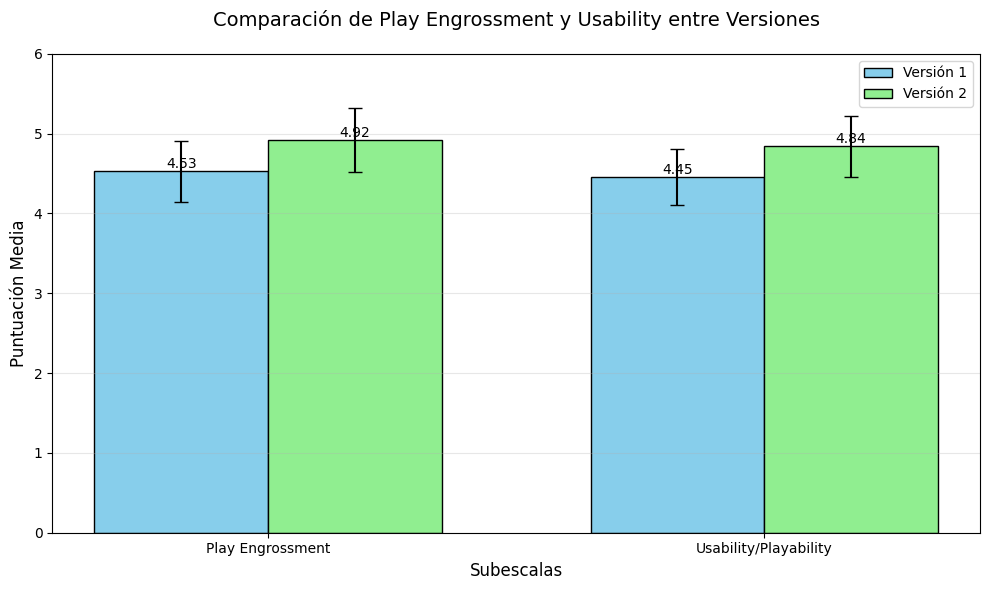

In [25]:
def grafico_comparativo_play_usability():
    # Seleccionar las subdimensiones a comparar
    subescalas_comparar = ["Play Engrossment", "Usability/Playability"]

    # Preparar datos para el gráfico
    medias_v1 = []
    medias_v2 = []
    errores_v1 = []
    errores_v2 = []

    for subescala in subescalas_comparar:
        columnas = subdimensiones[subescala]

        # Calcular medias y desviaciones estándar
        medias_v1.append(v1_data[columnas].mean(axis=1).mean())
        medias_v2.append(v2_data[columnas].mean(axis=1).mean())

        errores_v1.append(v1_data[columnas].mean(axis=1).std(ddof=1))
        errores_v2.append(v2_data[columnas].mean(axis=1).std(ddof=1))

    # Configurar el gráfico
    plt.figure(figsize=(10, 6))

    # Posiciones de las barras
    x = np.arange(len(subescalas_comparar))
    width = 0.35  # Ancho de las barras

    # Crear barras para v1 y v2
    bars_v1 = plt.bar(x - width/2, medias_v1, width, label='Versión 1',
                      color='skyblue', edgecolor='black', yerr=errores_v1, capsize=5)
    bars_v2 = plt.bar(x + width/2, medias_v2, width, label='Versión 2',
                      color='lightgreen', edgecolor='black', yerr=errores_v2, capsize=5)

    # Añadir etiquetas y título
    plt.xlabel('Subescalas', fontsize=12)
    plt.ylabel('Puntuación Media', fontsize=12)
    plt.title('Comparación de Play Engrossment y Usability entre Versiones', fontsize=14, pad=20)
    plt.xticks(x, subescalas_comparar)
    plt.legend()

    # Añadir los valores encima de las barras
    for bars in [bars_v1, bars_v2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

    # Ajustar límites del eje y
    plt.ylim(0, 6)

    # Mostrar grid
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Ejecutar la función
grafico_comparativo_play_usability()